<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/09_09_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 7 앙상블 학습과 랜덤 포레스트

앙상블 방법 : ex) 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기 훈련

예측을 하려면 모든 개별 트리의 예측을 구하면 됨. 그런 다음 가장 많은 선택을 받은 클래스로 예측을 삼음

- 앙상블 방법 : 결정 트리의 앙상블



## 7.1 투표 기반 분류기



In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
#각 분류기의 테스트셋 정확도

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.896


-> 투표 기반 분류기가 다른 개별 분류기보다 성능이 더 높음

- 간접 투표 : 확률이 가장 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 더 높음

voting="hard" 를 voting="soft" 로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨.

## 7.2 배깅과 페이스팅

- 배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식

- 페이스팅 : 중복을 허용하지 않고 샘플링 하는 방식

배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능.

배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능.

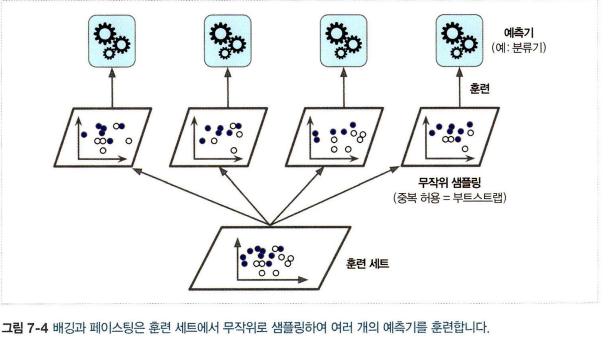

### 7.2.1 사이킷런의 배깅와 페이스팅

시이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier 회귀이면 BaggingRegressor 제공.



In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)  # n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정(-1로 지저앟면 가용한 모든 코어 사용)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 7.2.2 obb 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.

GabbingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택.

이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 된다는 것을 의미.

- 사이킷런에서 BaggingClassifier 만들 때, obb_score=True로 지정하면 훈련 끝난 후 자동으로 obb 평가 수행. 이는 obb_score_ 변수에 저장

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.88

In [7]:
#obb 샘플에 대한 결정 함수의 값도 obb_decision_function 함수에서 확인 가능

bag_clf.oob_decision_function_

array([[0.43478261, 0.56521739],
       [0.28494624, 0.71505376],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07103825, 0.92896175],
       [0.33502538, 0.66497462],
       [0.01675978, 0.98324022],
       [0.98901099, 0.01098901],
       [0.98295455, 0.01704545],
       [0.80555556, 0.19444444],
       [0.        , 1.        ],
       [0.7393617 , 0.2606383 ],
       [0.84158416, 0.15841584],
       [0.9516129 , 0.0483871 ],
       [0.06470588, 0.93529412],
       [0.        , 1.        ],
       [0.97979798, 0.02020202],
       [0.94512195, 0.05487805],
       [0.99519231, 0.00480769],
       [0.01149425, 0.98850575],
       [0.3423913 , 0.6576087 ],
       [0.88359788, 0.11640212],
       [1.        , 0.        ],
       [0.97826087, 0.02173913],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.59459459, 0.40540541],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특정 샘플링도 지원.

- 샘플링은 두 매개 변수로 조정
  : mac_features, bootstrap_features

이 기법은 이미지와 같이 매우 고차원 데이터셋을 다룰 때 유용.

- 랜덤 피치 방식 : 훈련 특성과 샘플을 모두 샘플링

- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용(bootstrao=False, max_samples=1.0)하고 특성은 샘플링(bootstrao=True, max_samples=1.0보다 작게 설정)하는 것.

## 7.4 랜덤 포레스트

전형적으로 max_samples 를 훈련 세트의 크기로 지정.

Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForesetClassifier 사용 가능.

In [8]:
# 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier는 몇 가지 예외가 있지만 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는데 필요한 BaggingClassifier의 매개변수를 모두 갖고 있음

랜덤 포레스트 알고리즘으 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성ㅇ르 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입.

이는 트리를 다양하게 만들고, 편향을 손해보는 대신 분산을 낮춤 -> 전체적으로 더 훌륭한 모델

In [9]:
# BaggingClassifier 사용해 FandomForestClassifier와 거의 유사하게 만듦

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

트리를 더욱 무작위하게 만들기 우해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택

- 사이킷런의 ExtraTreesClassifier 사용

### 7.4.2 특성 중요도



In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09824279149207527
sepal width (cm) 0.02434045831229967
petal length (cm) 0.43987333266878004
petal width (cm) 0.43754341752684506


## 7.5 부스팅

약한 연습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법.

### 7.5.1 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것으로 이전 예측기 보완



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 인전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴



In [11]:
# DecisionTreeRegressor를 훈련 세트에 학습시킴
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [12]:
# 두 번째 예측기가 만든 잔여 오차에 3번째 회귀 모델 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [13]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 세 개의 트리를 포함하는 앙상블 모델의 예측을 더하면 새로운 샘플에 대한 예측
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [15]:
# GradientBoostingRegressor 사용한 GBRT 앙상블

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

leaning_rate : 각 트리의 기여 정도 조절

* learning_rate 낮게 설정 (ex. 0.1)
    :앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐
    

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2)

In [17]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break    # 조기 종료

* 확률적 그레이디언트 부스팅 : subsample을 낮추어 편향이 높아지는 대신 분산을 낮추고 훈련 속도를 높임

In [18]:
# 최정화된 그레이디언트 부스팅
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [20]:
#XGBoost 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set =[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

## 7.6 스태킹
* 예측기들은 각각 다른 값을 예측하고 마지막 예측기(블레더 또는 메타 학습기)가 이 예측을 입력으로 받아 최종 예측을 만듦